In [11]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *

%matplotlib inline
np.random.seed(1)

y= 2


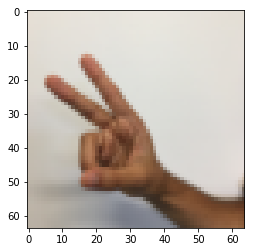

In [13]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()
plt.imshow(X_train_orig[6])
print('y=',np.squeeze(Y_train_orig[:,6]))

In [46]:
X_train = X_train_orig/255
X_test = X_test_orig/255
Y_train = convert_to_one_hot(Y_train_orig,6).T
Y_test = convert_to_one_hot(Y_test_orig,6).T
print('x train shape :',X_train.shape)
print('y train shape :',Y_train.shape)

print('x test shape :',X_test.shape)
print('y test shape :',Y_test.shape)

x train shape : (1080, 64, 64, 3)
y train shape : (1080, 6)
x test shape : (120, 64, 64, 3)
y test shape : (120, 6)


In [19]:
def create_placeholders(n_H0,n_W0,n_C0,n_y):
    x = tf.placeholder(tf.float32,shape = [None,n_H0,n_W0,n_C0])
    y = tf.placeholder(tf.float32,shape = [None,n_y])
    return x,y
X, Y = create_placeholders(64, 64, 3, 6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder_1:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_2:0", shape=(?, 6), dtype=float32)


In [23]:
def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 3, 8]
                        W2 : [2, 2, 8, 16]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    tf.set_random_seed(1)
    
    W1 = tf.get_variable('W1',[4,4,3,8],initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable('W2',[2,2,8,16],initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    
    parameters = {'W1':W1,'W2':W2}
    return parameters
tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print('w1',parameters['W1'].eval()[1,1,1]) ### why eval ?
    print('w2',parameters['W2'].eval()[1,1,1])

w1 [ 0.00131723  0.14176141 -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
w2 [-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]


In [33]:
def forward_propagation(X, parameters): ## after a conv, there is a relu
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    A1 = tf.nn.conv2d(X,W1,strides = [1,1,1,1],padding = 'SAME')
    
    A2 = tf.nn.relu(A1)
    
    A3 = tf.nn.max_pool(A2,ksize = [1,8,8,1],strides=[1,8,8,1],padding = 'SAME')
    
    A4 = tf.nn.conv2d(A3,W2,strides = [1,1,1,1],padding = 'SAME')
    
    A5 = tf.nn.relu(A4)
    
    A6 = tf.nn.max_pool(A5,[1,4,4,1],[1,4,4,1],padding = 'SAME')
    
    A7 = tf.contrib.layers.flatten(A6)
    
    Z3 = tf.contrib.layers.fully_connected(A7,6,activation_fn = None)
    
    return Z3


In [32]:
def compute_cost(Z3,Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits
                          (logits = Z3,labels = Y))
    return cost

In [57]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed = 3
    
    (m,n_H0,n_W0,n_C0)= X_train.shape
    n_y = Y_train.shape[1]
    costs = []
    
    X,Y = create_placeholders(n_H0,n_W0,n_C0,n_y)
    parameters = initialize_parameters()
    
    Z3 = forward_propagation(X,parameters)
    cost = compute_cost(Z3,Y)
    
    optimier = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):
            minibatch_cost = 0
            num_minibatches = int(m/minibatch_size)
            seed += 1
            minibatches = random_mini_batches(X_train,Y_train,minibatch_size,seed)
            
            for minibatch in minibatches:
                (minibatch_X,minibatch_Y) = minibatch
                _,temp_cost = sess.run([optimier,cost],
                                   feed_dict = {X:minibatch_X,Y:minibatch_Y})
            
                minibatch_cost += temp_cost/num_minibatches
            
            if print_cost == True and epoch %5 == 0:
                print('cost after epoch %i:%f'%(epoch,minibatch_cost))
            if print_cost == True and epoch %1 == 0:
                costs.append(minibatch_cost)
    
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations(per tens)')
        plt.title('learning rate = '+ str(learning_rate))
        plt.show()

        predict_op = tf.argmax(Z3,1)
        correct_prediction = tf.equal(predict_op,tf.argmax(Y,1))

        accuarcy = tf.reduce_mean(tf.cast(correct_prediction,"float"))
        train_accuarcy = accuarcy.eval({X:X_train,Y:Y_train})
        test_accuracy = accuarcy.eval({X:X_test,Y:Y_test})
        print('train accuracy ',train_accuarcy)
        print('test accuarcy',test_accuracy)

        return train_accuarcy,test_accuracy,parameters

cost after epoch 0:1.917929
cost after epoch 5:1.506757
cost after epoch 10:0.955359
cost after epoch 15:0.845802
cost after epoch 20:0.701173
cost after epoch 25:0.570725
cost after epoch 30:0.531806
cost after epoch 35:0.522357
cost after epoch 40:0.426237
cost after epoch 45:0.416917
cost after epoch 50:0.392239
cost after epoch 55:0.351203
cost after epoch 60:0.300881
cost after epoch 65:0.299140
cost after epoch 70:0.319066
cost after epoch 75:0.292510
cost after epoch 80:0.270511
cost after epoch 85:0.298058
cost after epoch 90:0.211864
cost after epoch 95:0.164706


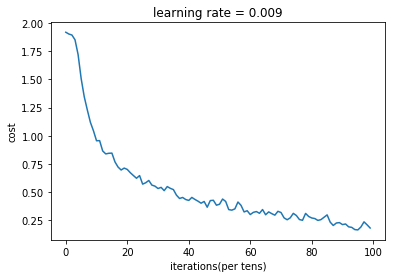

train accuracy  0.92963
test accuarcy 0.791667


In [58]:
_,_,parameters = model(X_train, Y_train, X_test, Y_test)